In [1]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import easyocr
import shutil
import json
import cv2
import os
import re

C:\Users\ASUS\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Detected Name Line
Text: nom et prénom de 'fadhérent abdengakblahan bjalolluajgrawul
x: 137, y: 260, width: 1533, height: 109
Saved name field at: cropped_fields\subscriber_name.jpg


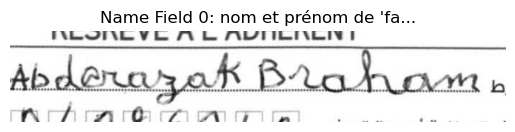

Detected Name Line
Text: nom et prénom du malade qjojlcl(jgrawul
x: 134, y: 1148, width: 1530, height: 58
Saved name field at: cropped_fields\patient_name.jpg


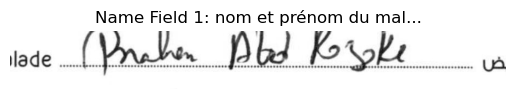

Detected CIN/Passport Line
Text: numéro cin ou passeport de4 1416 0 jqujl jlo ? 9l ëibojl lélsijl ëëly a1c
x: 136, y: 357, width: 1531, height: 90
Saved CIN/passport field at: cropped_fields\cin_passport_subscriber.jpg


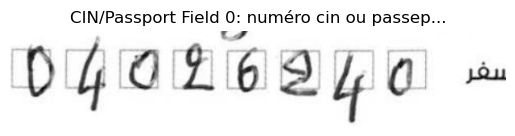

In [2]:
image_path = 'hi2.jpg'  
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise FileNotFoundError(f"Image not found at {image_path}")

reader = easyocr.Reader(['fr'])  

vertical_threshold = 15  
horizontal_gap_threshold = 50  

name_keywords = ['nom', 'prénom', 'adherant', 'malade']
cin_keywords = ['passeport']

results = reader.readtext(image)

lines = []
for bbox, text, conf in results:
    avg_y = np.mean([point[1] for point in bbox]) 
    matched = False
    for line in lines:
        if abs(line['avg_y'] - avg_y) < vertical_threshold:
            line['items'].append((bbox, text))
            matched = True
            break
    if not matched:
        lines.append({'avg_y': avg_y, 'items': [(bbox, text)]})

name_lines = []
cin_lines = []
for line in lines:
    items = sorted(line['items'], key=lambda x: min(p[0] for p in x[0]))  
    full_text = ' '.join([text for _, text in items]).lower()

    if any(keyword in full_text for keyword in name_keywords):
        all_points = [pt for bbox, _ in items for pt in bbox]
        all_points = np.array(all_points)
        x_min, y_min = np.min(all_points, axis=0).astype(int)
        x_max, y_max = np.max(all_points, axis=0).astype(int)
        width = x_max - x_min
        height = y_max - y_min
        name_lines.append({
            'text': full_text,
            'x': x_min,
            'y': y_min,
            'width': width,
            'height': height
        })

    if any(keyword in full_text for keyword in cin_keywords):
        all_points = [pt for bbox, _ in items for pt in bbox]
        all_points = np.array(all_points)
        x_min, y_min = np.min(all_points, axis=0).astype(int)
        x_max, y_max = np.max(all_points, axis=0).astype(int)
        width = x_max - x_min
        height = y_max - y_min
        cin_lines.append({
            'text': full_text,
            'x': x_min,
            'y': y_min,
            'width': width,
            'height': height
        })

base_name = os.path.splitext(os.path.basename(image_path))[0]

output_directory = 'cropped_fields'
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)
os.makedirs(output_directory, exist_ok=True)

saved_images = []

for idx, line in enumerate(name_lines):
    x, y, w, h = line['x'], line['y'], line['width'], line['height']
    
    print("Detected Name Line")
    print(f"Text: {line['text']}")
    print(f"x: {x}, y: {y}, width: {w}, height: {h}")

    if idx == 0:  
        extended_left = 430  
        extended_right = -240  
        extended_top = -25    
        extended_bottom = 25  
    elif idx == 1:  
        extended_left = 400
        extended_right = -230
        extended_top = -22
        extended_bottom = 25
    else: 
        extended_left = 430
        extended_right = -230
        extended_top = -25
        extended_bottom = 25

    x_left = max(0, x + extended_left)
    x_right = min(image.shape[1], x + w + extended_right)
    y_top = max(0, y + extended_top)
    y_bottom = min(image.shape[0], y + h + extended_bottom)

    if x_right <= x_left or y_bottom <= y_top:
        print(f"Invalid crop dimensions for name field: "
              f"x_left={x_left}, x_right={x_right}, y_top={y_top}, y_bottom={y_bottom}. Skipping...")
        continue

    cropped_region = image[y_top:y_bottom, x_left:x_right]
    
    if cropped_region.size == 0:
        print(f"Empty crop detected for name field. Skipping...")
        continue

    if idx == 0 and not any(img['name'] == 'subscriber_name' for img in saved_images):
        filename = 'subscriber_name.jpg'
    elif idx == 1 and not any(img['name'] == 'patient_name' for img in saved_images):
        filename = 'patient_name.jpg'
    else:
        filename = f"{base_name}_name_{idx}.jpg"  

    output_path = os.path.join(output_directory, filename)
    cv2.imwrite(output_path, cropped_region)
    print(f"Saved name field at: {output_path}")
    saved_images.append({'name': filename})

    plt.imshow(cropped_region, cmap='gray')
    plt.title(f"Name Field {idx}: {line['text'][:20]}...")
    plt.axis('off')
    plt.show()

for idx, line in enumerate(cin_lines):
    x, y, w, h = line['x'], line['y'], line['width'], line['height']

    print("Detected CIN/Passport Line")
    print(f"Text: {line['text']}")
    print(f"x: {x}, y: {y}, width: {w}, height: {h}")
    
    extended_left = 430  
    extended_right = -500  
    extended_top = -5
    extended_bottom = 20

    x_left = max(0, x + extended_left)
    x_right = min(image.shape[1], x + w + extended_right)
    y_top = max(0, y + extended_top)
    y_bottom = min(image.shape[0], y + h + extended_bottom)

    if x_right <= x_left or y_bottom <= y_top:
        print(f"Invalid crop dimensions for CIN/passport field: "
              f"x_left={x_left}, x_right={x_right}, y_top={y_top}, y_bottom={y_bottom}. Skipping...")
        continue

    cropped_region = image[y_top:y_bottom, x_left:x_right]

    if cropped_region.size == 0:
        print(f"Empty crop detected for CIN/passport field. Skipping...")
        continue

    if not any(img['name'] == 'cin_passport_subscriber' for img in saved_images):
        filename = 'cin_passport_subscriber.jpg'
    else:
        filename = f"{base_name}_cin_passport_{idx}.jpg" 

    output_path = os.path.join(output_directory, filename)
    cv2.imwrite(output_path, cropped_region)
    print(f"Saved CIN/passport field at: {output_path}")
    saved_images.append({'name': filename})

    plt.imshow(cropped_region, cmap='gray')
    plt.title(f"CIN/Passport Field {idx}: {line['text'][:20]}...")
    plt.axis('off')
    plt.show()

C:\Users\ASUS\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ASUS\anaconda3\Lib\site-packages\transformers\generation\utils.py:1254: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


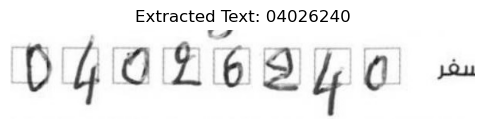

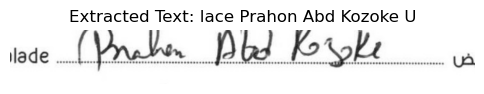

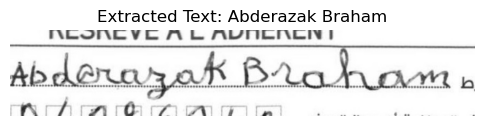

Saved extracted text to: cropped_fields\extracted_text.json


In [3]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")

output_directory = "cropped_fields"  

def clean_text(text, field_name):
    if 'cin_passport_subscriber' in field_name:
        cleaned = re.sub(r'[^0-9]', '', text)
        return cleaned if cleaned else ""  
    else:
        cleaned = re.sub(r'[^a-zA-Z ]', '', text)
        cleaned = ' '.join(cleaned.split())  
        return cleaned if cleaned else ""  

extracted_text_dict = {}
cropped_files = sorted(os.listdir(output_directory))
for cropped_file in cropped_files:
    if cropped_file.endswith('.jpg'):  
        cropped_path = os.path.join(output_directory, cropped_file)

        pil_image = Image.open(cropped_path).convert("RGB")

        pixel_values = processor(images=pil_image, return_tensors="pt").pixel_values
        generated_ids = model.generate(pixel_values)
        extracted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        
        filename_key = os.path.splitext(cropped_file)[0]  
        cleaned_text = clean_text(extracted_text, filename_key)
        
        extracted_text_dict[filename_key] = cleaned_text

        plt.figure(figsize=(6, 4))
        plt.imshow(pil_image)
        plt.axis("off")
        plt.title(f"Extracted Text: {cleaned_text}")
        plt.show()

json_output_path = os.path.join(output_directory, 'extracted_text.json')
with open(json_output_path, 'w', encoding='utf-8') as json_file:
    json.dump(extracted_text_dict, json_file, ensure_ascii=False, indent=4)
print(f"Saved extracted text to: {json_output_path}")